# Black box

## Częśc 1

### Impot i Feature engeneering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import mstats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss, roc_curve

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor
from interpret import show


In [2]:
df = pd.read_csv('zbior_10.csv')
target_col = 'default' 

X = df.drop(columns=[target_col])
y = df[target_col]

In [3]:
def full_feature_engineering(df):
    cols_to_drop = [c for c in df.columns if c.startswith('wsk_') or c.startswith('schemat_')]
    cols_to_drop += ['RP_przeplywy_operacyjne', 'RP_amortyzacja']
    df_new = df.drop(columns=cols_to_drop, errors='ignore').copy()

    df_new['PKD_Kod'] = df_new['pkdKod'].fillna(0).astype(int).astype(str)
    df_new['PKD_Dzial'] = df_new['PKD_Kod'].str[:2].astype('category')

    def safe_div(a, b):
        return np.divide(a, b, out=np.zeros_like(a, dtype=float), where=b != 0)

    df_new['New_Current_Ratio'] = safe_div(df_new['Aktywa_obrotowe'], df_new['Zobowiazania_krotkoterminowe'])
    df_new['New_Cash_Ratio'] = safe_div(df_new['Srodki_pieniezne'], df_new['Zobowiazania_krotkoterminowe'])

    zob_total = df_new['Zobowiazania_krotkoterminowe'] + df_new['Zobowiazania_dlugoterminowe']
    df_new['New_Debt_Ratio'] = safe_div(zob_total, df_new['Aktywa'])
    df_new['New_Equity_Multiplier'] = safe_div(df_new['Aktywa'], df_new['Kapital_wlasny'])

    df_new['New_ROA'] = safe_div(df_new['Zysk_netto'], df_new['Aktywa'])
    df_new['New_ROS'] = safe_div(df_new['Zysk_netto'], df_new['przychody'])
    df_new['New_Op_Margin'] = safe_div(df_new['zysk_operacyjny'], df_new['przychody'])

    df_new['New_Asset_Turnover'] = safe_div(df_new['przychody'], df_new['Aktywa'])
    df_new['New_Receivables_Cycle'] = safe_div(df_new['Naleznosci_krotkoterminowe'], df_new['przychody'])

    for col in ['Aktywa', 'przychody', 'zysk_brutto']:
        df_new[f'Log_{col}'] = np.log1p(df_new[col].clip(lower=0))

    ebitda = df_new['zysk_operacyjny'].fillna(0) + df_new['amortyzacja'].fillna(0)
    df_new['Calc_EBITDA'] = ebitda
    df_new['Ratio_Interest_Coverage'] = safe_div(ebitda, df_new['koszty_odsetki'].fillna(0))

    total_debt = df_new['Zobowiazania_krotkoterminowe'].fillna(0) + df_new['Zobowiazania_dlugoterminowe'].fillna(0)
    net_debt = total_debt - df_new['Srodki_pieniezne'].fillna(0)
    df_new['Ratio_NetDebt_EBITDA'] = safe_div(net_debt, ebitda)

    df_new['Cycle_Receivables'] = safe_div(df_new['Naleznosci_krotkoterminowe'], df_new['przychody'])
    df_new['Cycle_Inventory'] = safe_div(df_new['Zapasy'], df_new['koszty_operacyjne'])
    df_new['Cycle_Payables'] = safe_div(df_new['Zobowiazania_krotkoterminowe'], df_new['koszty_operacyjne'])
    df_new['Cycle_Gap'] = df_new['Cycle_Payables'] - df_new['Cycle_Receivables']

    permanent_capital = df_new['Kapital_wlasny'].fillna(0) + df_new['Zobowiazania_dlugoterminowe'].fillna(0)
    df_new['Rule_Golden'] = safe_div(permanent_capital, df_new['Aktywa_trwale'])
    df_new['Structure_Debt_LongTerm'] = safe_div(df_new['Zobowiazania_dlugoterminowe'], total_debt)

    rel_receivables = df_new['Naleznosci_dostaw_uslug_12m_powiazane'].fillna(0) + df_new['Naleznosci_dostaw_uslug_pow12m_powiazane'].fillna(0)
    df_new['Risk_Related_Receivables'] = safe_div(rel_receivables, df_new['Aktywa'])

    rel_payables = df_new['Zobowiazania_dostaw_uslug_12m_powiazane'].fillna(0) + df_new['Zobowiazania_dostaw_uslug_pow12m_powiazane'].fillna(0)
    df_new['Risk_Related_Payables'] = safe_div(rel_payables, total_debt)

    df_new['Log_EBITDA'] = np.log1p(df_new['Calc_EBITDA'].clip(lower=0))

    return df_new

X_fin = full_feature_engineering(X)


In [4]:
X_fin.shape

(3000, 105)

### Podział danych oraz kolejne trasformacje

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_fin, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)
print(f"{X_train.shape}")
print(f"{X_val.shape}")
print(f"{X_test.shape}")

(1800, 105)
(600, 105)
(600, 105)


In [6]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
skewness_before = X_train[numeric_cols].apply(lambda x: stats.skew(x.dropna()))
print(skewness_before)


szczegolnaFormaPrawna_Symbol          NaN
formaWlasnosci_Symbol           -3.334566
pkdKod                          -0.313350
Aktywa                          33.596866
Aktywa_trwale                   16.293453
                                  ...    
Rule_Golden                     25.111751
Structure_Debt_LongTerm          2.604039
Risk_Related_Receivables         8.738642
Risk_Related_Payables            7.704519
Log_EBITDA                      -0.530985
Length: 103, dtype: float64


In [7]:
def winsorize_and_transform(X_train, X_test, X_val):
    X_train_proc = X_train.copy()
    X_test_proc = X_test.copy()
    X_val_proc = X_val.copy()
    
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    for col in numeric_cols:
        q_low = X_train_proc[col].quantile(0.01)
        q_high = X_train_proc[col].quantile(0.99)
        
        X_train_proc[col] = np.clip(X_train_proc[col], q_low, q_high)
        X_test_proc[col] = np.clip(X_test_proc[col], q_low, q_high)
        X_val_proc[col] = np.clip(X_val_proc[col], q_low, q_high)
    
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    X_train_proc[numeric_cols] = pt.fit_transform(X_train_proc[numeric_cols])
    X_test_proc[numeric_cols] = pt.transform(X_test_proc[numeric_cols])
    X_val_proc[numeric_cols] = pt.transform(X_val_proc[numeric_cols])
    
    return X_train_proc, X_test_proc, X_val_proc

X_train_vin, X_test_vin, X_val_vin = winsorize_and_transform(X_train, X_test, X_val)

print("Winsoryzacja i transformacja Yeo-Johnson zakończona")
print(f"X_train_vin shape: {X_train_vin.shape}")
print(f"X_test_vin shape: {X_test_vin.shape}")
print(f"X_val_vin shape: {X_val_vin.shape}")


Winsoryzacja i transformacja Yeo-Johnson zakończona
X_train_vin shape: (1800, 105)
X_test_vin shape: (600, 105)
X_val_vin shape: (600, 105)


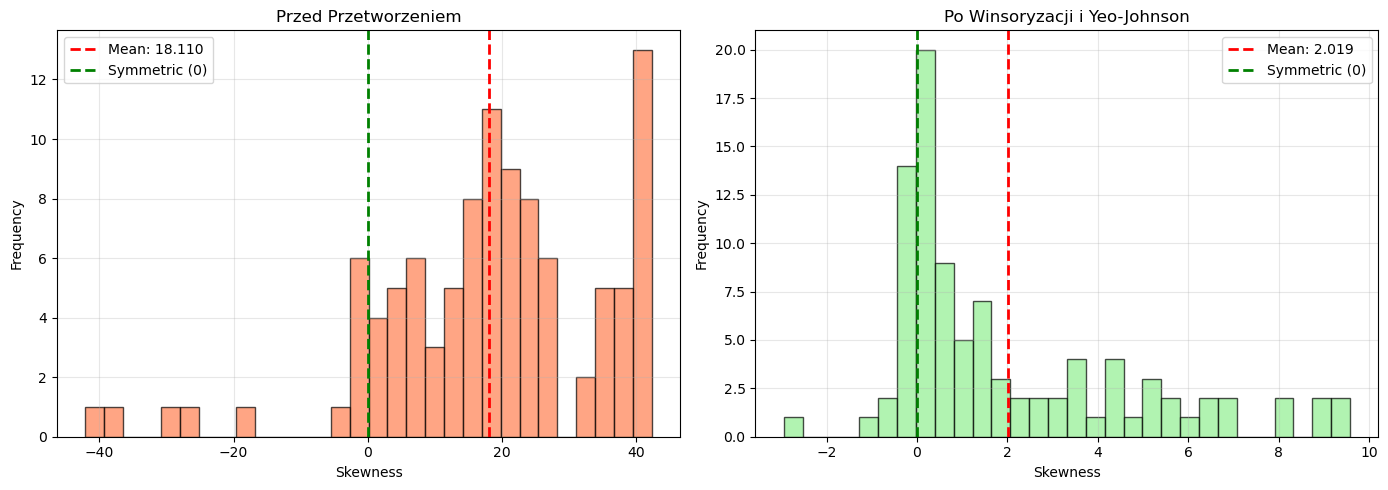

In [8]:
numeric_cols = X_train_vin.select_dtypes(include=[np.number]).columns.tolist()
skewness_after = X_train_vin[numeric_cols].apply(lambda x: stats.skew(x.dropna()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(skewness_before, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0].axvline(skewness_before.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {skewness_before.mean():.3f}')
axes[0].axvline(0, color='green', linestyle='--', linewidth=2, label='Symmetric (0)')
axes[0].set_xlabel('Skewness')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Przed Przetworzeniem')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(skewness_after, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].axvline(skewness_after.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {skewness_after.mean():.3f}')
axes[1].axvline(0, color='green', linestyle='--', linewidth=2, label='Symmetric (0)')
axes[1].set_xlabel('Skewness')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Po Winsoryzacji i Yeo-Johnson')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [9]:
def add_anomaly_feature(X_train, X_test, X_val):
    X_train_out = X_train.copy()
    X_test_out = X_test.copy()
    X_val_out = X_val.copy()
    
    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    
    X_train_imputed = imputer.fit_transform(X_train[num_cols])
    X_test_imputed = imputer.transform(X_test[num_cols])
    X_val_imputed = imputer.transform(X_val[num_cols])
    
    iso = IsolationForest(n_estimators=100, random_state=42, n_jobs=-1)
    iso.fit(X_train_imputed)
    
    X_train_out['Anomaly_Score'] = iso.decision_function(X_train_imputed)
    X_test_out['Anomaly_Score'] = iso.decision_function(X_test_imputed)
    X_val_out['Anomaly_Score'] = iso.decision_function(X_val_imputed)
    
    return X_train_out, X_test_out, X_val_out

X_train_final, X_test_final, X_val_final = add_anomaly_feature(X_train, X_test, X_val)


KOLUMNY O KORELACJI > 0.95 (34 par)
                              Kolumna 1                                Kolumna 2  Korelacja
                  New_Receivables_Cycle                        Cycle_Receivables   1.000000
                  New_Receivables_Cycle                                Cycle_Gap  -0.999994
                      Cycle_Receivables                                Cycle_Gap  -0.999994
         Naleznosci_dostaw_uslug_pow12m         Zobowiazania_dostaw_uslug_pow12m   0.999994
Naleznosci_dostaw_uslug_pow12m_kapitale   Zobowiazania_dostaw_uslug_12m_kapitale   0.999580
                    przychody_sprzedazy                                przychody   0.998405
             Naleznosci_krotkoterminowe           Naleznosci_dostaw_uslug_pow12m   0.997740
             Naleznosci_krotkoterminowe         Zobowiazania_dostaw_uslug_pow12m   0.997733
             Naleznosci_krotkoterminowe             Zobowiazania_krotkoterminowe   0.997165
           Zobowiazania_krotkoterminowe     

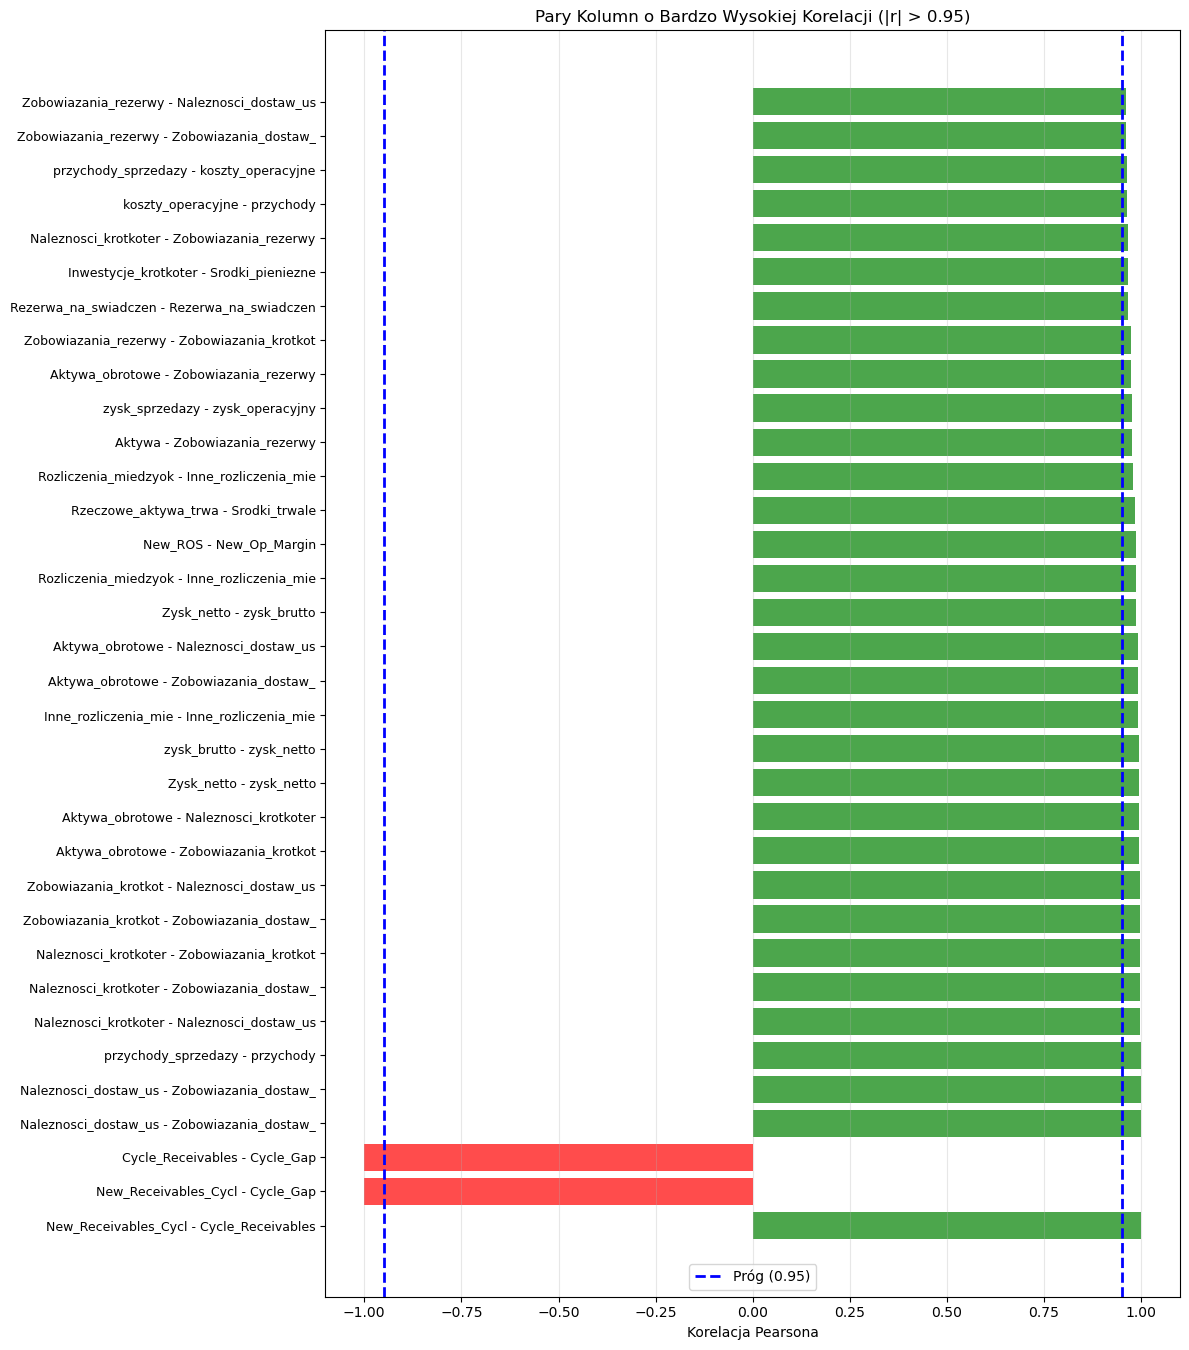


Liczba par kolumn: 5253
Średnia |korelacja|: 0.0903
Mediana |korelacja|: 0.0214
Max |korelacja|: 1.0000
Pary z |korelacją| > 0.8: 58
Pary z |korelacją| > 0.9: 43
Pary z |korelacją| > 0.95: 34


In [10]:

numeric_cols = X_train_final.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = X_train_final[numeric_cols].corr()

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            high_corr_pairs.append({
                'Kolumna 1': corr_matrix.columns[i],
                'Kolumna 2': corr_matrix.columns[j],
                'Korelacja': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Korelacja', ascending=False, key=abs)
    
    print("=" * 80)
    print(f"KOLUMNY O KORELACJI > 0.95 ({len(high_corr_df)} par)")
    print("=" * 80)
    print(high_corr_df.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(12, max(6, len(high_corr_df) * 0.4)))
    pairs_labels = [f"{row['Kolumna 1'][:20]} - {row['Kolumna 2'][:20]}" 
                    for _, row in high_corr_df.iterrows()]
    colors = ['green' if x > 0 else 'red' for x in high_corr_df['Korelacja'].values]
    
    ax.barh(range(len(high_corr_df)), high_corr_df['Korelacja'].values, color=colors, alpha=0.7)
    ax.set_yticks(range(len(high_corr_df)))
    ax.set_yticklabels(pairs_labels, fontsize=9)
    ax.axvline(x=0.95, color='blue', linestyle='--', linewidth=2, label='Próg (0.95)')
    ax.axvline(x=-0.95, color='blue', linestyle='--', linewidth=2)
    ax.set_xlabel('Korelacja Pearsona')
    ax.set_title('Pary Kolumn o Bardzo Wysokiej Korelacji (|r| > 0.95)')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("  BRAK kolumn o korelacji wyższej niż 0.95")
    print(f"  Liczba kolumn: {len(numeric_cols)}")
    print(f"  Max korelacja między kolumnami: {corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().abs().max():.4f}")

print("\n" + "=" * 80)
print("=" * 80)
corr_values = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack()
print(f"Liczba par kolumn: {len(corr_values)}")
print(f"Średnia |korelacja|: {abs(corr_values).mean():.4f}")
print(f"Mediana |korelacja|: {abs(corr_values).median():.4f}")
print(f"Max |korelacja|: {abs(corr_values).max():.4f}")
print(f"Pary z |korelacją| > 0.8: {len(corr_values[abs(corr_values) > 0.8])}")
print(f"Pary z |korelacją| > 0.9: {len(corr_values[abs(corr_values) > 0.9])}")
print(f"Pary z |korelacją| > 0.95: {len(corr_values[abs(corr_values) > 0.95])}")


In [11]:
cols_to_drop = ['New_Receivables_Cycle'] 
if 'zysk_netto' in X_train_final.columns and 'Zysk_netto' in X_train_final.columns:
    cols_to_drop.append('zysk_netto')
if 'Zobowiazania_dostaw_uslug_pow12m' in X_train_final.columns:
    cols_to_drop.append('Zobowiazania_dostaw_uslug_pow12m')

X_train_final = X_train_final.drop(columns=cols_to_drop, errors='ignore')
X_test_final = X_test_final.drop(columns=cols_to_drop, errors='ignore')
X_val_final = X_val_final.drop(columns=cols_to_drop, errors='ignore')


print(f"  X_train_final: {X_train_final.shape}")
print(f"  X_test_final: {X_test_final.shape}")
print(f"  X_val_final: {X_val_final.shape}")


  X_train_final: (1800, 103)
  X_test_final: (600, 103)
  X_val_final: (600, 103)


## Część 2
Trenowanie modeli Black Box

##### Używane metryki

In [12]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, log_loss, brier_score_loss

def evaluate_model(y_true, y_pred_proba, model_name="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    ks_statistic = max(tpr - fpr)
    
    logloss = log_loss(y_true, y_pred_proba)
    
    brier = brier_score_loss(y_true, y_pred_proba)
    
    results = {
        'Model': model_name,
        'AUC-ROC': roc_auc,
        'PR-AUC': pr_auc,
        'KS Statistic': ks_statistic,
        'Log Loss': logloss,
        'Brier Score': brier
    }
    
    return results

def print_evaluation(results):
    print("=" * 70)
    print(f"WYNIKI EWALUACJI: {results['Model']}")
    print("=" * 70)
    print(f"AUC-ROC:       {results['AUC-ROC']:.4f}")
    print(f"PR-AUC:        {results['PR-AUC']:.4f}")
    print(f"KS Statistic:  {results['KS Statistic']:.4f}")
    print(f"Log Loss:      {results['Log Loss']:.4f}")
    print(f"Brier Score:   {results['Brier Score']:.4f}")
    print("=" * 70)


### LightGMB